In [144]:
# import dependencies
import yfinance as yf
import pandas as pd
from prophet import Prophet

%matplotlib inline
import matplotlib.pyplot as plt

import os
import requests
import json
from dotenv import load_dotenv


## Step 1 : Retrieve Stock Data with the yFinance SDK
1. **Get the Top 3 Companies by Sector:**
    - Use the `yFinance` SDK to retrieve a list of the top 3 companies within each sector.
2. **Obtain 5 years of Historical Data.**
    - Pull historical stock data for each of these companies, covering the past 5 years to analyze performance and trends.

In [183]:
# Define the sectors to analyze
sectors = ['technology', 'healthcare', 'financial-services', 'energy', 'consumer-cyclical']
top_sector_dfs = []

for sector in sectors:

    # Retrieve the top companies in the current sector (outputs a DataFrame)
    top_companies = yf.Sector(sector).top_companies

    # Filter out records where the 'rating' column is None to avoid any issues
    # and retrieve the top 3 companies with a valid rating
    top_3_companies = top_companies[top_companies['rating'].notna()].head(3)

    # Add a 'sector' column to identify the sector for each company
    top_3_companies['sector'] = sector

    # Append the DataFrame to the list for later concatenation
    top_sector_dfs.append(top_3_companies)
    
# Combine all sector data into a single DataFrame
top_companies_df = pd.concat(top_sector_dfs, axis=0)
top_companies_df

,name,rating,market weight,sector
symbol,,,,
NVDA,NVIDIA Corporation,Buy,0.188519,technology
AAPL,Apple Inc.,Buy,0.175659,technology
MSFT,Microsoft Corporation,Buy,0.163001,technology
LLY,Eli Lilly and Company,Buy,0.115294,healthcare
UNH,UnitedHealth Group Incorporated,Buy,0.083898,healthcare
JNJ,Johnson & Johnson,Buy,0.054506,healthcare
BRK-B,Berkshire Hathaway Inc.,Buy,0.099661,financial-services
JPM,JPMorgan Chase & Co.,Buy,0.079825,financial-services
V,Visa Inc.,Buy,0.059657,financial-services


In [184]:
# Get all the symbols into a list
tickers = top_companies_df.index.to_list()
print(tickers)

['NVDA', 'AAPL', 'MSFT', 'LLY', 'UNH', 'JNJ', 'BRK-B', 'JPM', 'V', 'XOM', 'CVX', 'COP', 'AMZN', 'TSLA', 'HD']


In [185]:
# Dictionary to store historical data for each ticker
historical_data = {}

for ticker in tickers:
    
    # Initialize the ticker object
    stock = yf.Ticker(ticker)

    # Retrieve 5 years of historical market data for the current ticker
    historical_data[ticker] = stock.history(period="5y")

    # Add the ticker symbol as a column to the DataFrame
    historical_data[ticker]['Symbol'] = ticker


In [186]:
# Create a DataFrame for the historical data
historical_df = pd.concat(historical_data, axis = 0)

# Display the first 5 and last 5 rows of the DataFrame
display(historical_df.head(5))
display(historical_df.tail(5))

Open      High       Low     Close  \
     Date                                                                
NVDA 2019-11-13 00:00:00-05:00  5.183537  5.211153  5.122584  5.189011   
     2019-11-14 00:00:00-05:00  5.197967  5.221602  5.138009  5.219363   
     2019-11-15 00:00:00-05:00  5.217124  5.268872  4.991720  5.080041   
     2019-11-18 00:00:00-05:00  5.072577  5.307932  5.069591  5.281312   
     2019-11-19 00:00:00-05:00  5.250213  5.273848  5.116364  5.174581   

                                    Volume  Dividends  Stock Splits Symbol  
     Date                                                                   
NVDA 2019-11-13 00:00:00-05:00   300188000        0.0           0.0   NVDA  
     2019-11-14 00:00:00-05:00   518080000        0.0           0.0   NVDA  
     2019-11-15 00:00:00-05:00  1053628000        0.0           0.0   NVDA  
     2019-11-18 00:00:00-05:00   574588000        0.0           0.0   NVDA  
     2019-11-19 00:00:00-05:00   414564000        0.0           0.0   NVDA

Open        High         Low       Close  \
   Date                                                                        
HD 2024-11-06 00:00:00-05:00  394.040009  394.040009  381.720001  388.369995   
   2024-11-07 00:00:00-05:00  391.000000  399.760010  390.799988  399.440002   
   2024-11-08 00:00:00-05:00  404.000000  406.399994  402.299988  405.899994   
   2024-11-11 00:00:00-05:00  407.769989  411.600006  405.829987  408.290009   
   2024-11-12 00:00:00-05:00  414.250000  416.019989  402.190002  403.079987   

                               Volume  Dividends  Stock Splits Symbol  
   Date                                                                
HD 2024-11-06 00:00:00-05:00  7133400        0.0           0.0     HD  
   2024-11-07 00:00:00-05:00  4323100        0.0           0.0     HD  
   2024-11-08 00:00:00-05:00  3448700        0.0           0.0     HD  
   2024-11-11 00:00:00-05:00  4071500        0.0           0.0     HD  
   2024-11-12 00:00:00-05:00  5641900        0.0           0.0     HD

In [187]:
# The dataframe has multiple indices.  So, we need to drop the first and just keep the Date as index
historical_df = historical_df.reset_index(level=0, drop=True)

# Convert the index to datetime
historical_df.index = pd.to_datetime(historical_df.index)

# Remove the timestamp and keep only the date part
historical_df.index = historical_df.index.date

# Display the DataFrame to check
display(historical_df.head())

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Symbol
2019-11-13,5.183537,5.211153,5.122584,5.189011,300188000,0.0,0.0,NVDA
2019-11-14,5.197967,5.221602,5.138009,5.219363,518080000,0.0,0.0,NVDA
2019-11-15,5.217124,5.268872,4.991720,5.080041,1053628000,0.0,0.0,NVDA
2019-11-18,5.072577,5.307932,5.069591,5.281312,574588000,0.0,0.0,NVDA
2019-11-19,5.250213,5.273848,5.116364,5.174581,414564000,0.0,0.0,NVDA


## Step 2 : Create visuals to determine interesting patters within these stocks

1. A regular (linear scale) graph to observe absolute price growth.
2. A logarithmic scale graph to focus on relative (percentage-based) growth.

- **Regular Scale Graph:** Highlights the absolute stock price increases over time. This graph is particularly useful for identifying which stock has the highest dollar-value growth.

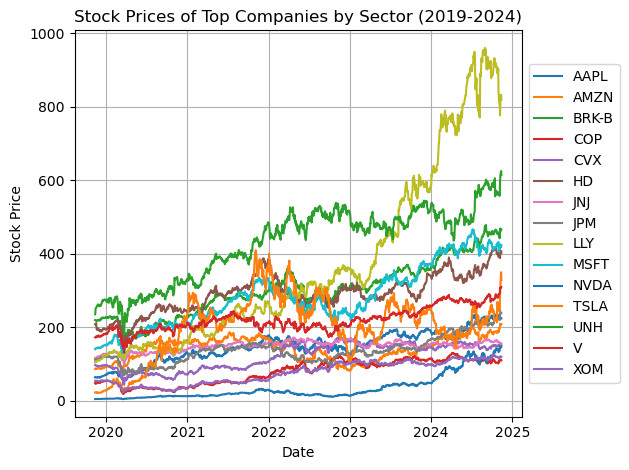

In [199]:
# plot the visualization for the stock price

historical_df.groupby('Symbol')['Close'].plot()

# Add the legend to the visual
plt.legend(title = 'Ticker')

plt.title("Stock Prices of Top Companies by Sector (2019-2024)")
plt.grid(True)

# Add the axis labels
plt.xlabel('Date')
plt.ylabel('Stock Price')

# Adjust legend placement
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Display the graph with the added features
plt.tight_layout()
plt.show()

- **Logarithmic Scale Graph:** Emphasizes the relative (percentage) growth of each stock, making it easier to compare growth rates.

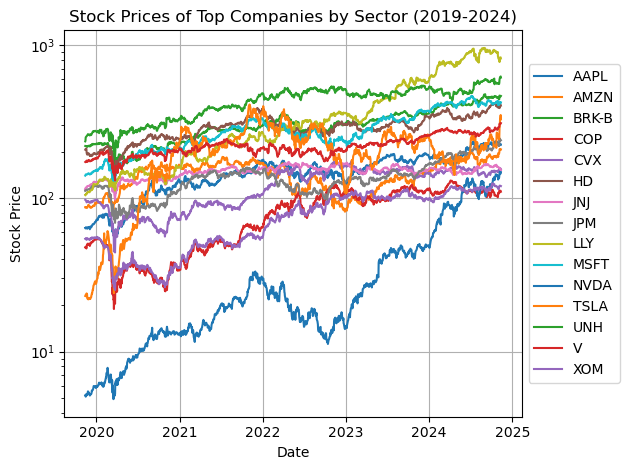

In [200]:
# plot the visualization for the stock price

historical_df.groupby('Symbol')['Close'].plot()

# Log scale on y-axis
plt.yscale('log')

# Add the legend to the visual
plt.legend(title = 'Ticker')

plt.title("Stock Prices of Top Companies by Sector (2019-2024)")
plt.grid(True)

# Add the axis labels
plt.xlabel('Date')
plt.ylabel('Stock Price')

# Adjust legend placement
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Display the graph with the added features
plt.tight_layout()
plt.show()

**Question:** What pattern looks more interesting?

**LLY (Eli Lilly)** and **NVDA (NVIDIA)** seem to be the interesting candidates for further analysis with financial data, as they both exhibit standout patterns that suggest potential insights:
- **LLY (Eli Lilly)** shows the most notable absolute price increase, suggesting strong performance in dollar terms. 
- **NVDA (NVIDIA)** has experienced the highest relative growth over the period, which is interesting because it indicates a dramatic percentage increase from its initial value.


In [283]:
# Filter the DataFrame to keep only rows with 'Symbol' as 'NVDA' or 'LLY'
historical_df= historical_df.loc[historical_df['Symbol'].isin(['NVDA', 'LLY'])]

# Display the first and last 5 records to verify the slice
display(historical_df.head())
display(historical_df.tail())

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Symbol
2019-11-13,5.183537,5.211153,5.122584,5.189011,300188000,0.0,0.0,NVDA
2019-11-14,5.197967,5.221602,5.138009,5.219363,518080000,0.0,0.0,NVDA
2019-11-15,5.217124,5.268872,4.991720,5.080041,1053628000,0.0,0.0,NVDA
2019-11-18,5.072577,5.307932,5.069591,5.281312,574588000,0.0,0.0,NVDA
2019-11-19,5.250213,5.273848,5.116364,5.174581,414564000,0.0,0.0,NVDA


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Symbol
2024-11-06,817.330017,820.729980,767.609985,776.380005,8257900,0.0,0.0,LLY
2024-11-07,784.650024,802.549988,778.190002,797.450012,4557600,0.0,0.0,LLY
2024-11-08,803.500000,847.270020,801.260010,831.539978,7212900,0.0,0.0,LLY
2024-11-11,831.299988,844.000000,824.630005,832.440002,3342800,0.0,0.0,LLY
2024-11-12,830.200012,833.989990,810.719971,818.859985,3376300,0.0,0.0,LLY


---

## Step 3: Retrieve Financial Data with the Alpha Vantage API

1. **Get Income Statement and Cash Flow Data:**
    - Use the Alpha Vantage API to retrieve financial data for each company, including the Income Statement and Cash Flow reports.
    - Focus on key metrics such as `Total Revenue` and `Free Cash Flow` to assess financial health.

2. **Calculate Net Profit Margin:**
    - From the Income Statement, use `Net Profit` and `Total Revenue` to calculate the **Net Profit Margin** for each company, which helps measure profitability.

In [202]:
# Load environment variables from the .env file
load_dotenv()

# Access the ALPHA_API_KEY
alpha_api_key = os.getenv("ALPHA_API_KEY")


In [240]:
# List of tickers selected for further analysis
selected_tickers = ['LLY', 'NVDA']

### Retrieve Income Statements Data

In [ ]:
# Initialize an empty list to store quarterly income statements for each ticker
alpha_quarterly_income_statements = []

# Loop through each ticker in the selected tickers list
for ticker in selected_tickers:
    
    # Construct the API URL to fetch the income statement data for the current ticker
    url = f"https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={ticker}&apikey={alpha_api_key}"
    
    # Send a GET request to the API and retrieve the response in JSON format
    response = requests.get(url).json()
    
    # Loop through each quarterly report in the response (if available)
    for report in response.get("quarterlyReports", []):
        # Add the ticker symbol to each report to identify the data's source
        report["symbol"] = ticker

    # Append the list of quarterly reports to the main list (or an empty list if no reports are available)
    alpha_quarterly_income_statements.append(response.get("quarterlyReports", []))

In [237]:
# Initialize an empty list to store the extracted data
income_statements_data= []

# Loop through each quarterly report in the ticker's income statements
for ticker in alpha_quarterly_income_statements:

    for _ in ticker: 
        
         # Create a dictionary for the extracted fields
        record = {
            'Date': pd.to_datetime(_['fiscalDateEnding']), 
            'Symbol': _['symbol'], 
            'Gross Profit': int(_['grossProfit']), 
            'Total Revenue': int(_['totalRevenue'])
        }
        
        # Append the dictionary to the data list
        income_statements_data.append(record)

In [ ]:
# Create a DataFrame from the data and set 'Date' as the index
income_statements_df = pd.DataFrame(income_statements_data).set_index('Date')

# Show the first and last 5 records
display(income_statements_df.head())
display(income_statements_df.tail())

,Symbol,Gross Profit,Total Revenue
Date,,,
2024-09-30,LLY,7202300000,11439100000
2024-06-30,LLY,6694700000,11302800000
2024-03-31,LLY,5258400000,8768000000
2023-12-31,LLY,5182500000,9353400000
2023-09-30,LLY,5950100000,9498600000


,Symbol,Gross Profit,Total Revenue
Date,,,
2009-07-26,NVDA,156723000,776520000
2009-04-26,NVDA,189696000,664231000
2009-01-25,NVDA,141666000,481140000
2008-10-26,NVDA,367843000,897655000
2008-07-27,NVDA,149917000,892676000


### Retrieve Cashflow data

In [250]:
# Initialize an empty list to store quarterly CashFlow for each ticker
alpha_quarterly_cashflow = []

# Loop through each ticker in the selected tickers list
for ticker in selected_tickers:
    
    # Construct the API URL to fetch the Cash Flow data for the current ticker
    casflow_url = f"https://www.alphavantage.co/query?function=CASH_FLOW&symbol={ticker}&apikey={alpha_api_key}"
    
    # Send a GET request to the API and retrieve the response in JSON format
    response = requests.get(casflow_url).json()
    
    # Loop through each quarterly report in the response (if available)
    for _ in response.get("quarterlyReports", []):
        # Add the ticker symbol to each report to identify the data's source
        _["symbol"] = ticker

    # Append the list of quarterly reports to the main list (or an empty list if no reports are available)
    alpha_quarterly_cashflow.append(response.get("quarterlyReports", []))

In [277]:
# Initialize an empty list to store the extracted data
cashflow_data= []

# Loop through each quarterly report in the ticker's income statements
for ticker in alpha_quarterly_cashflow:

    for _ in ticker: 
        
         # Create a dictionary for the extracted fields
        record = {
            'Date': pd.to_datetime(_['fiscalDateEnding']), 
            'Symbol': _['symbol'], 
            'Operating Cashflow': int(_['operatingCashflow']), 
            'Capital Expenditures': int(_['capitalExpenditures']),
            'Net Income': int(_['netIncome'])
        }
        
        # Append the dictionary to the data list
        cashflow_data.append(record)

In [278]:
# Create a DataFrame from the data and set 'Date' as the index
cashflow_df = pd.DataFrame(cashflow_data).set_index('Date')

# Show the first and last 5 records
display(cashflow_df.head())
display(cashflow_df.tail())

,Symbol,Operating Cashflow,Capital Expenditures,Net Income
Date,,,,
2024-09-30,LLY,3711900000,1350700000,970300000
2024-06-30,LLY,1466200000,1224800000,2967000000
2024-03-31,LLY,1166000000,986300000,2242900000
2023-12-31,LLY,-311900000,1070600000,2189700000
2023-09-30,LLY,2189500000,970300000,-57400000


,Symbol,Operating Cashflow,Capital Expenditures,Net Income
Date,,,,
2010-10-31,NVDA,212177000,21823000,84862000
2010-08-01,NVDA,34344000,37644000,-140961000
2010-05-02,NVDA,-5397000,17080000,137594000
2010-01-31,NVDA,69245000,22575000,131076000
2009-10-25,NVDA,141317000,16593000,107577000


In [279]:
# Calculate Free Cash Flow and add it as a new column
cashflow_df['Free Cash Flow (FCF)'] = cashflow_df['Operating Cashflow'] - cashflow_df['Capital Expenditures']

# Display the first few rows to verify the new column
cashflow_df.head()

,Symbol,Operating Cashflow,Capital Expenditures,Net Income,Free Cash Flow (FCF)
Date,,,,,
2024-09-30,LLY,3711900000,1350700000,970300000,2361200000
2024-06-30,LLY,1466200000,1224800000,2967000000,241400000
2024-03-31,LLY,1166000000,986300000,2242900000,179700000
2023-12-31,LLY,-311900000,1070600000,2189700000,-1382500000
2023-09-30,LLY,2189500000,970300000,-57400000,1219200000


## Merge the datasets

In [ ]:
# Merge the income statements data with cashflow data on 'Date' and 'Symbol'
company_finance_df = pd.merge(income_statements_df, cashflow_df, on=["Date", "Symbol"])

# Set 'Date' as the index in the merged DataFrame
company_finance_df.set_index("Date", inplace=True)

# Drop the extra 'level_0' and 'index' columns
company_finance_df = company_finance_df.drop(columns=["level_0", "index"])

# Display the result
display(company_finance_df.head())

,Symbol,Gross Profit,Total Revenue,Operating Cashflow,Capital Expenditures,Net Income,Free Cash Flow (FCF)
Date,,,,,,,
2024-09-30,LLY,7202300000,11439100000,3711900000,1350700000,970300000,2361200000
2024-06-30,LLY,6694700000,11302800000,1466200000,1224800000,2967000000,241400000
2024-03-31,LLY,5258400000,8768000000,1166000000,986300000,2242900000,179700000
2023-12-31,LLY,5182500000,9353400000,-311900000,1070600000,2189700000,-1382500000
2023-09-30,LLY,5950100000,9498600000,2189500000,970300000,-57400000,1219200000


In [ ]:
# Calculate 'Net Profit Margin' and add it as a new column
company_finance_df['Net Profit Margin (%)'] = (company_finance_df['Net Income'] / company_finance_df['Total Revenue']) * 100

# Display the first few rows to verify the new column
company_finance_df.head()

,Symbol,Gross Profit,Total Revenue,Operating Cashflow,Capital Expenditures,Net Income,Free Cash Flow (FCF),Net Profit Margin (%)
Date,,,,,,,,
2024-09-30,LLY,7202300000,11439100000,3711900000,1350700000,970300000,2361200000,8.482311
2024-06-30,LLY,6694700000,11302800000,1466200000,1224800000,2967000000,241400000,26.250133
2024-03-31,LLY,5258400000,8768000000,1166000000,986300000,2242900000,179700000,25.580520
2023-12-31,LLY,5182500000,9353400000,-311900000,1070600000,2189700000,-1382500000,23.410738
2023-09-30,LLY,5950100000,9498600000,2189500000,970300000,-57400000,1219200000,-0.604300


In [ ]:
company_finance_df = pd.to_datetime(company_finance_df.index)

In [284]:
display(historical_df)
display(company_finance_df)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Symbol
2019-11-13,5.183537,5.211153,5.122584,5.189011,300188000,0.0,0.0,NVDA
2019-11-14,5.197967,5.221602,5.138009,5.219363,518080000,0.0,0.0,NVDA
2019-11-15,5.217124,5.268872,4.991720,5.080041,1053628000,0.0,0.0,NVDA
2019-11-18,5.072577,5.307932,5.069591,5.281312,574588000,0.0,0.0,NVDA
2019-11-19,5.250213,5.273848,5.116364,5.174581,414564000,0.0,0.0,NVDA
...,...,...,...,...,...,...,...,...
2024-11-06,817.330017,820.729980,767.609985,776.380005,8257900,0.0,0.0,LLY
2024-11-07,784.650024,802.549988,778.190002,797.450012,4557600,0.0,0.0,LLY
2024-11-08,803.500000,847.270020,801.260010,831.539978,7212900,0.0,0.0,LLY
2024-11-11,831.299988,844.000000,824.630005,832.440002,3342800,0.0,0.0,LLY


,Symbol,Gross Profit,Total Revenue,Operating Cashflow,Capital Expenditures,Net Income,Free Cash Flow (FCF),Net Profit Margin (%)
Date,,,,,,,,
2024-09-30,LLY,7202300000,11439100000,3711900000,1350700000,970300000,2361200000,8.482311
2024-06-30,LLY,6694700000,11302800000,1466200000,1224800000,2967000000,241400000,26.250133
2024-03-31,LLY,5258400000,8768000000,1166000000,986300000,2242900000,179700000,25.580520
2023-12-31,LLY,5182500000,9353400000,-311900000,1070600000,2189700000,-1382500000,23.410738
2023-09-30,LLY,5950100000,9498600000,2189500000,970300000,-57400000,1219200000,-0.604300
...,...,...,...,...,...,...,...,...
2010-10-31,NVDA,392062000,843912000,212177000,21823000,84862000,190354000,10.055788
2010-08-01,NVDA,134292000,811208000,34344000,37644000,-140961000,-3300000,-17.376678
2010-05-02,NVDA,456377000,1001813000,-5397000,17080000,137594000,-22477000,13.734499


---

## Visualizations

Symbol
LLY     Axes(0.125,0.11;0.775x0.77)
NVDA    Axes(0.125,0.11;0.775x0.77)
Name: Close, dtype: object

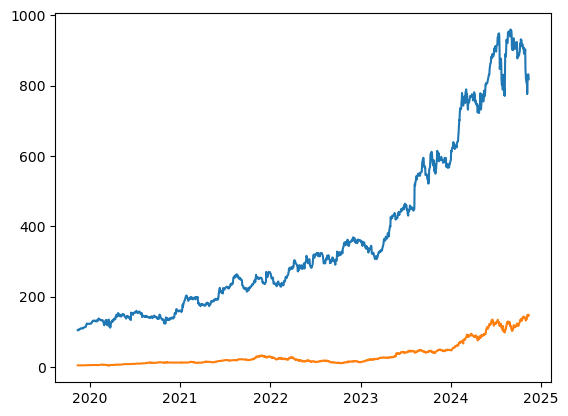

In [296]:
historical_df.groupby('Symbol')['Close'].plot()

In [ ]:
df_LLY = historical_df.loc[historical_df['Symbol'] == 'LLY']
df_LLY

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Symbol
2019-11-13,105.358071,105.974142,104.779332,105.283394,3250600,0.000,0.0,LLY
2019-11-14,105.325632,105.485229,104.208440,104.574577,2627100,0.645,0.0,LLY
2019-11-15,104.518254,106.855901,104.518254,106.264450,4857400,0.000,0.0,LLY
2019-11-18,106.104856,107.146941,105.954649,107.090614,3361600,0.000,0.0,LLY
2019-11-19,107.053070,109.015197,106.790203,108.057602,3781600,0.000,0.0,LLY
...,...,...,...,...,...,...,...,...
2024-11-06,817.330017,820.729980,767.609985,776.380005,8257900,0.000,0.0,LLY
2024-11-07,784.650024,802.549988,778.190002,797.450012,4557600,0.000,0.0,LLY
2024-11-08,803.500000,847.270020,801.260010,831.539978,7212900,0.000,0.0,LLY
2024-11-11,831.299988,844.000000,824.630005,832.440002,3342800,0.000,0.0,LLY


In [291]:
df_NVDA = historical_df.loc[historical_df['Symbol'] == 'NVDA']
df_NVDA

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Symbol
2019-11-13,5.183537,5.211153,5.122584,5.189011,300188000,0.0,0.0,NVDA
2019-11-14,5.197967,5.221602,5.138009,5.219363,518080000,0.0,0.0,NVDA
2019-11-15,5.217124,5.268872,4.991720,5.080041,1053628000,0.0,0.0,NVDA
2019-11-18,5.072577,5.307932,5.069591,5.281312,574588000,0.0,0.0,NVDA
2019-11-19,5.250213,5.273848,5.116364,5.174581,414564000,0.0,0.0,NVDA
...,...,...,...,...,...,...,...,...
2024-11-06,142.960007,146.490005,141.960007,145.610001,242043900,0.0,0.0,NVDA
2024-11-07,146.389999,148.929993,146.169998,148.880005,207323300,0.0,0.0,NVDA
2024-11-08,148.770004,149.770004,146.259995,147.630005,175665800,0.0,0.0,NVDA
2024-11-11,148.679993,148.850006,143.570007,145.259995,182325600,0.0,0.0,NVDA


<Axes: >

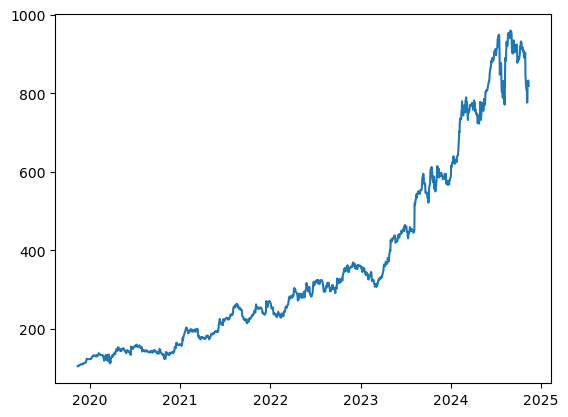

In [293]:
df_LLY['Close'].plot()

<Axes: >

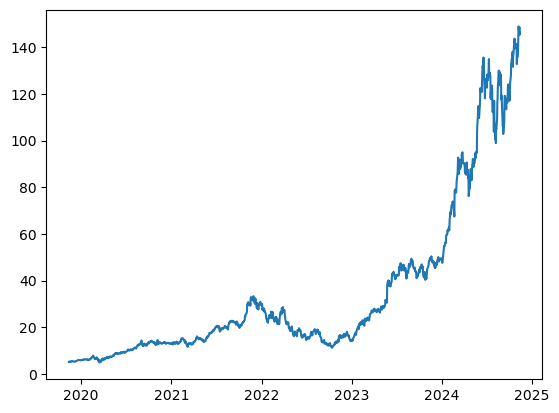

In [294]:
df_NVDA['Close'].plot()